In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob # list out all files in a directory

import soundfile as sf
import librosa
import librosa.display
import os

from collections import Counter
from pathlib import Path

# to be able to play audio files in notebook
import IPython.display as ipd

In [ ]:
# we have to import the audio from google drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
audio_files = glob("/content/drive/MyDrive/ECS 171/music-genre-classification/Raw Audio Data/genres_original/*/*.wav") # change this, leave * and the last folder (mine is Raw Audio Data) is where all the audio files are stored
# the first * is for the various folders split by genre and the second *.wav is for the individual audio files

Terminology for Audio Files

1. Frequency (Hz)
- The differences in wavelengths in a file
- High frequency = short wavelength = more oscillations
- Pitch

2. Intensity (db/power)
- The amplitude
- How high are each of the waves
- Loudness

3. Sample rate
- When a computer processes audio, it has discrete observations of the audio file
    - Isn't continuous like true sound
- Sampling rate = how often the audio is processed
- Think of it as the resolution
- Higher sample rate = more detail
- At a certain threshold of sample rate, our ears will hear most of the audio

In [ ]:
# can listen to our audio here, but can't manipulate raw audio data yet

ipd.Audio(audio_files[0])

In [ ]:
# need librosa to manipulate raw audio data

y, sr = librosa.load(audio_files[0])
# y = raw data of audio file
# sr = integer value of sample rate

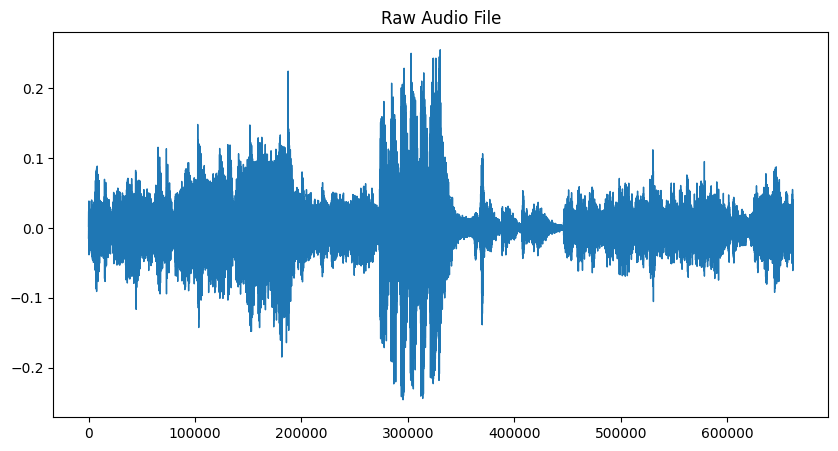

In [ ]:
pd.Series(y).plot(figsize=(10,5), lw=1, title='Raw Audio File')
plt.show()

In [ ]:
# to trim any silence at the beginning/end of recordings

y_trimmed, _ = librosa.effects.trim(y, top_db = 20) # gives us trimmed audio files (not saving indices)

# has an argument top_db where you can set the top decibel that gets trimmed at

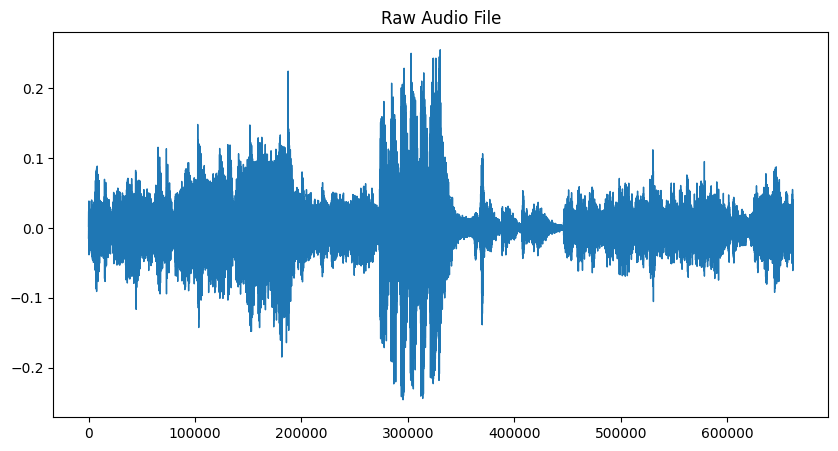

In [ ]:
pd.Series(y_trimmed).plot(figsize=(10,5), lw=1, title='Raw Audio File')
plt.show()

Fourier Transform
- What frequencies are sounding at different parts of the audio file
- Converting from time domain (what a microphone would record) to frequency domain
- Moves from time vs amplitude to frequencies (pitch) and magnitudes (how loud)

In [ ]:
# STFT

D = librosa.stft(y) # transforming y to frequency space using Fourier Transformation
# splits y into short, overlapping windows and applies FT on each window
# then use absolute value to get the strength of each frequency (how strong it is)

S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max) # converting from amplitude to log decibals (so it can be understood as how loud)

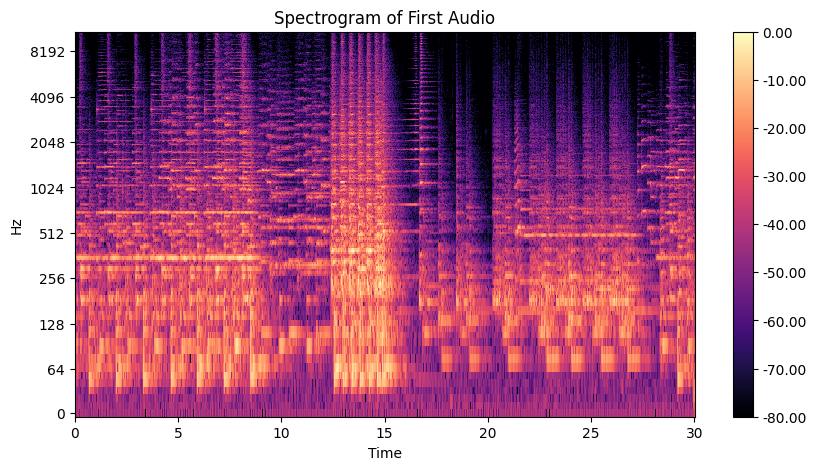

In [ ]:
# plotting spectrogram (transformed data)

fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax) # creating a spectrogram image so we can visualize this transformed data

ax.set_title("Spectrogram of First Audio")
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

Creating a Mel-spectrogram
- Mel = melodic
- Instead of fourier transform, apply mel spectrogram
- FT tells us what frequencies are present, whereas a mel spectrogram tells us how humans perceive those frequencies

Problems with STFT
- Humans don't hear frequencies linearly
- We are very sensitive to differences at low frequencies, but less sensitive to high frequencies
- STFT treats slight changes in low frequencies and slight changes in high frequencies equally, when really they should be weighted differently since humans perceive them differently

Selecting Number of Perceptual Frequency bands
64-128 = standard for music ML
High # (256) = prone to overfitting

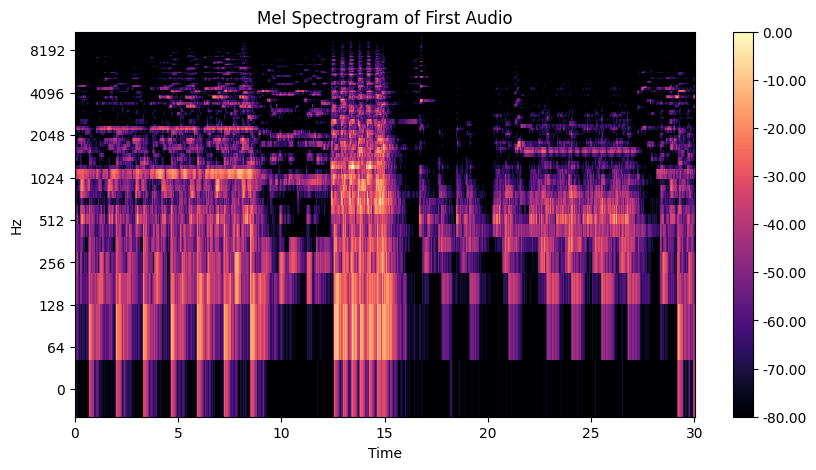

In [ ]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128) # creating mel spectrogram, sr = sampling rate we grabbed from raw audio data
# n_mels = how many perceptual frequency bands do you want (how finely to slice frequency axis to best represent how humans hear it)

S_db_mel = librosa.amplitude_to_db(np.abs(S), ref=np.max) # converting from amplitude to log decibals (so it can be understood as how loud)

fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db_mel, x_axis='time', y_axis='log', ax=ax) # creating a spectrogram image so we can visualize this transformed data

ax.set_title("Mel Spectrogram of First Audio")
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

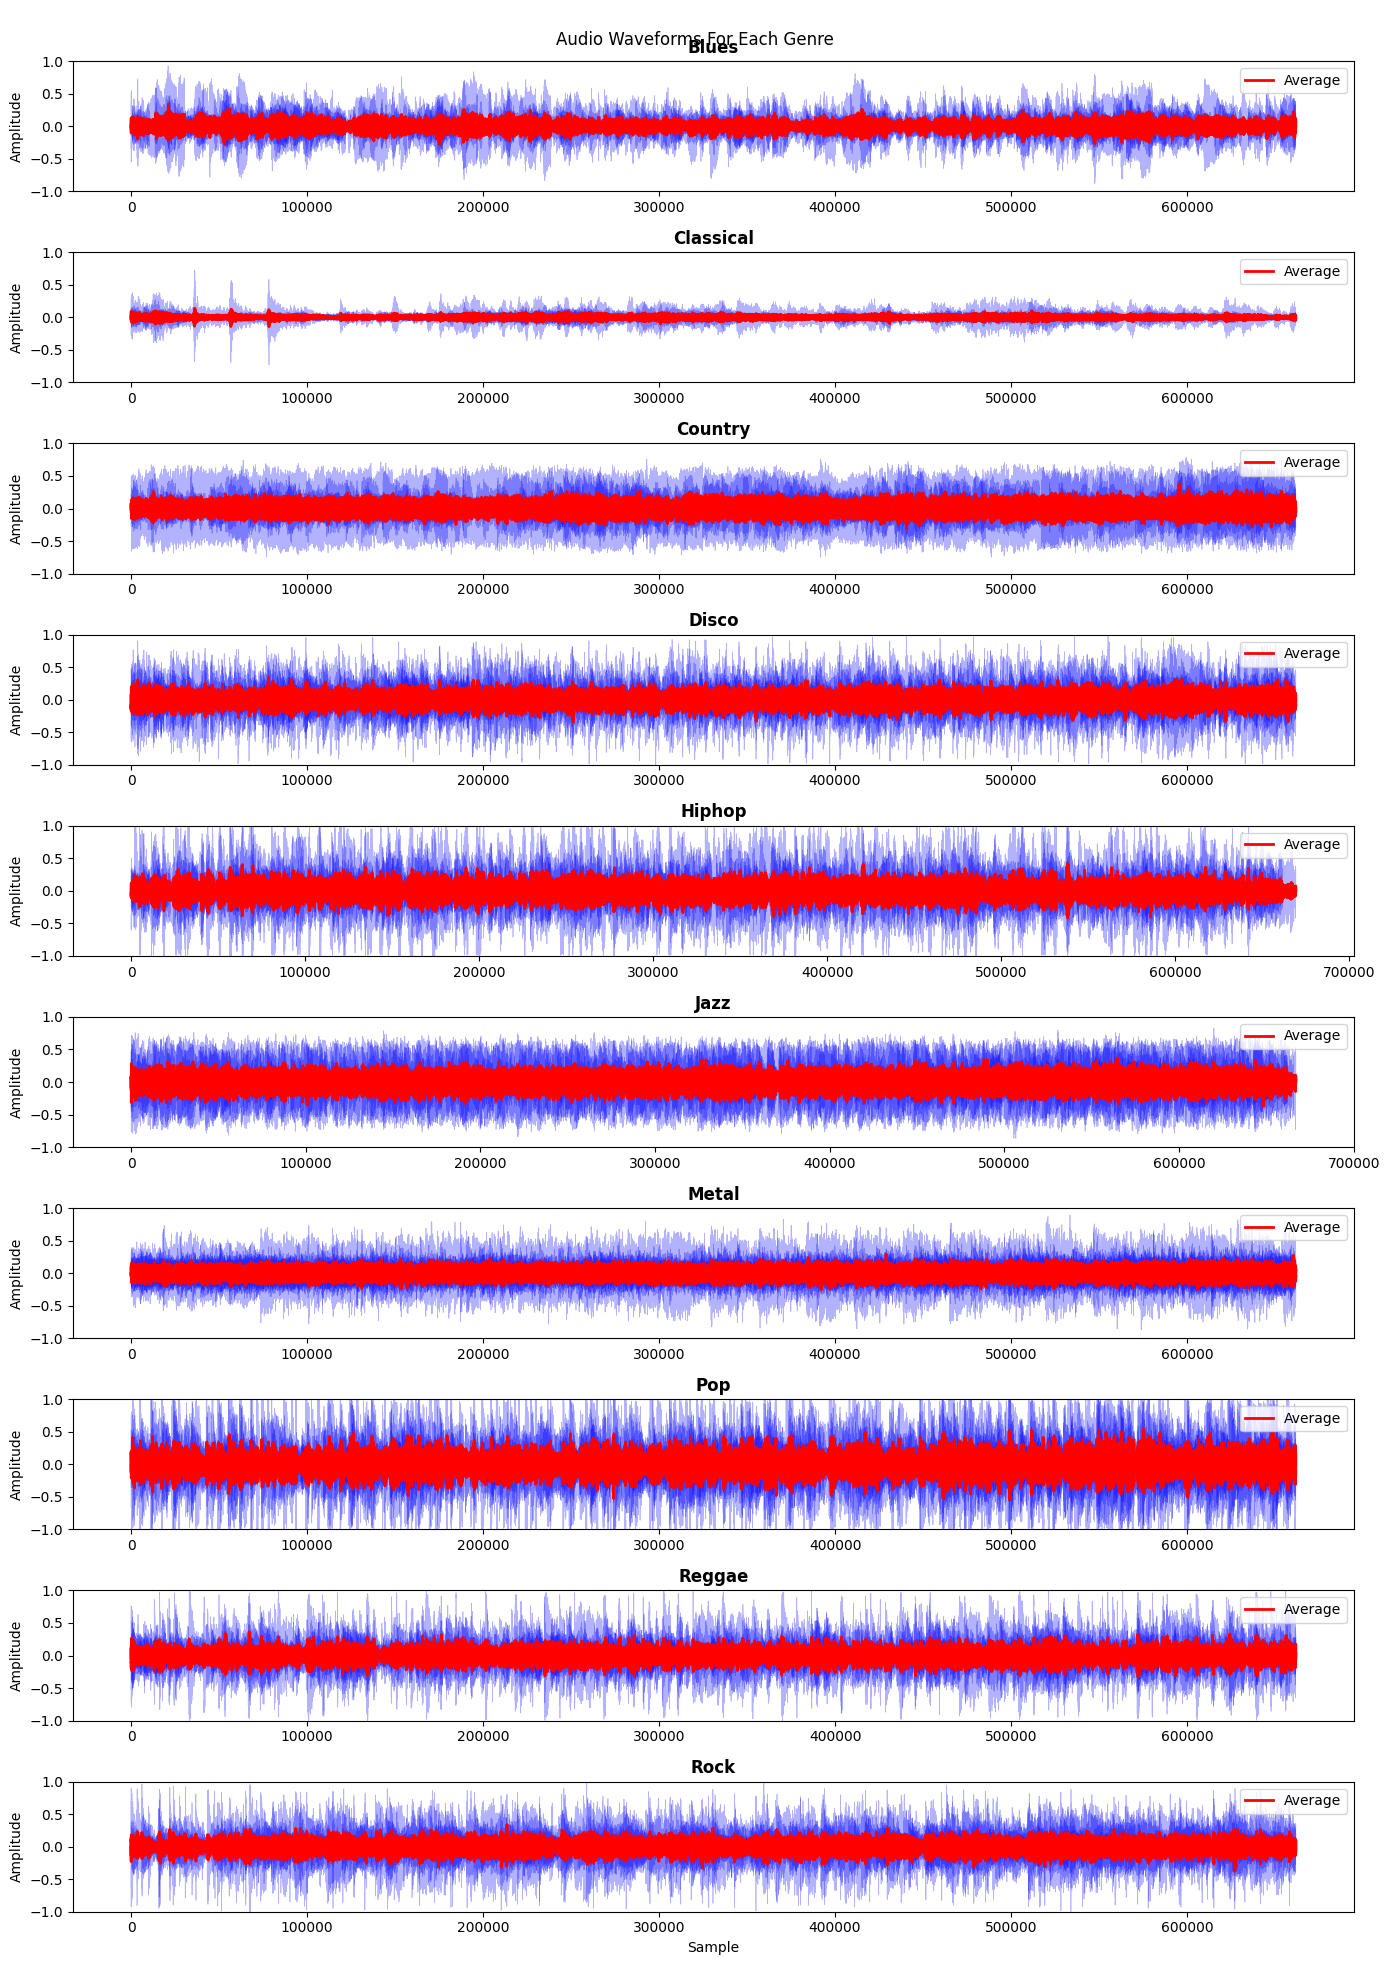

In [ ]:
# Data Plots



# 5 samples for each genre
genres_list = list(set([os.path.basename(os.path.dirname(f)) for f in audio_files]))

n_samples = 5

fig, axes = plt.subplots(len(genres_list), 1, figsize=(14, 20))

fig.suptitle('\nAudio Waveforms For Each Genre', fontsize=12)

for idx, genre in enumerate(sorted(genres_list)):

    # Get files for this genre

    genre_files = [f for f in audio_files if genre in f]

    # loading the samples
    samples_to_plot = np.random.choice(genre_files, n_samples, replace=False)

    all_waveforms = []

    for file in samples_to_plot:

        y_temp, sr_temp = librosa.load(file)

        all_waveforms.append(y_temp)

        axes[idx].plot(y_temp, alpha=0.3, linewidth=0.5, color='blue')

    # average waveform for all the same lengths

    max_len = max([len(w) for w in all_waveforms])

    padded_waveforms = [np.pad(w, (0, max_len - len(w))) for w in all_waveforms]

    avg_waveform = np.mean(padded_waveforms, axis=0)

    axes[idx].plot(avg_waveform, color='red', linewidth=2, label='Average')

    axes[idx].set_title(f'{genre.capitalize()}', fontsize=12, fontweight='bold')

    axes[idx].set_ylabel('Amplitude')

    axes[idx].legend(loc='upper right')

    axes[idx].set_ylim(-1, 1)

axes[-1].set_xlabel('Sample')

plt.tight_layout()

plt.show()


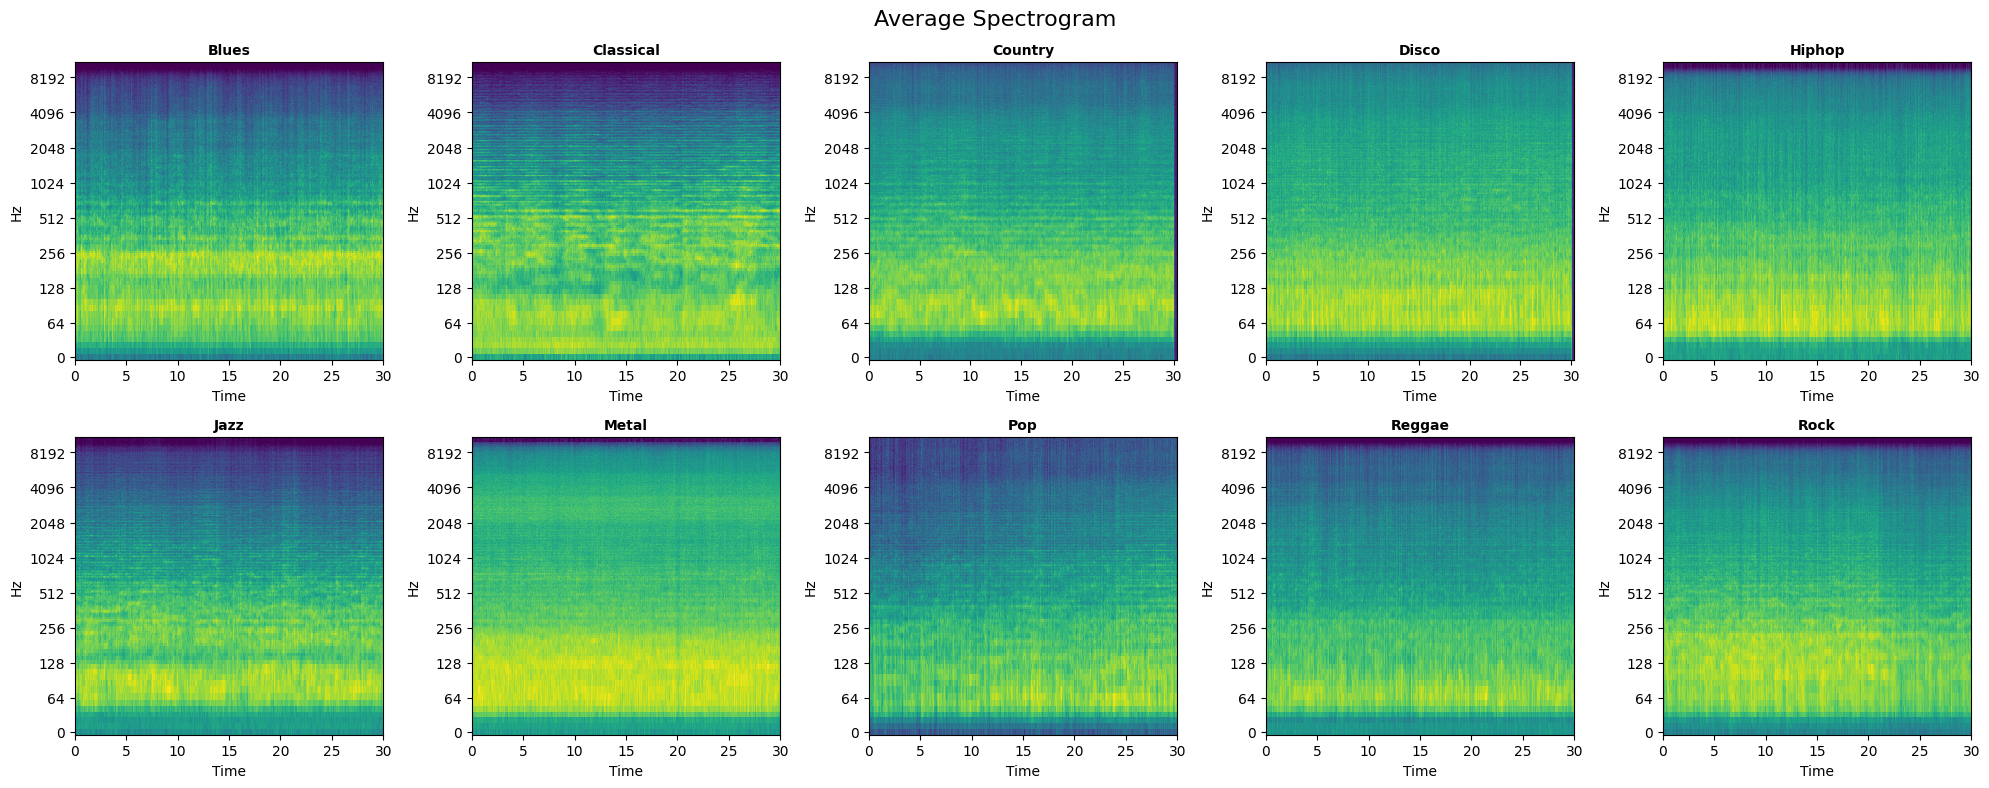

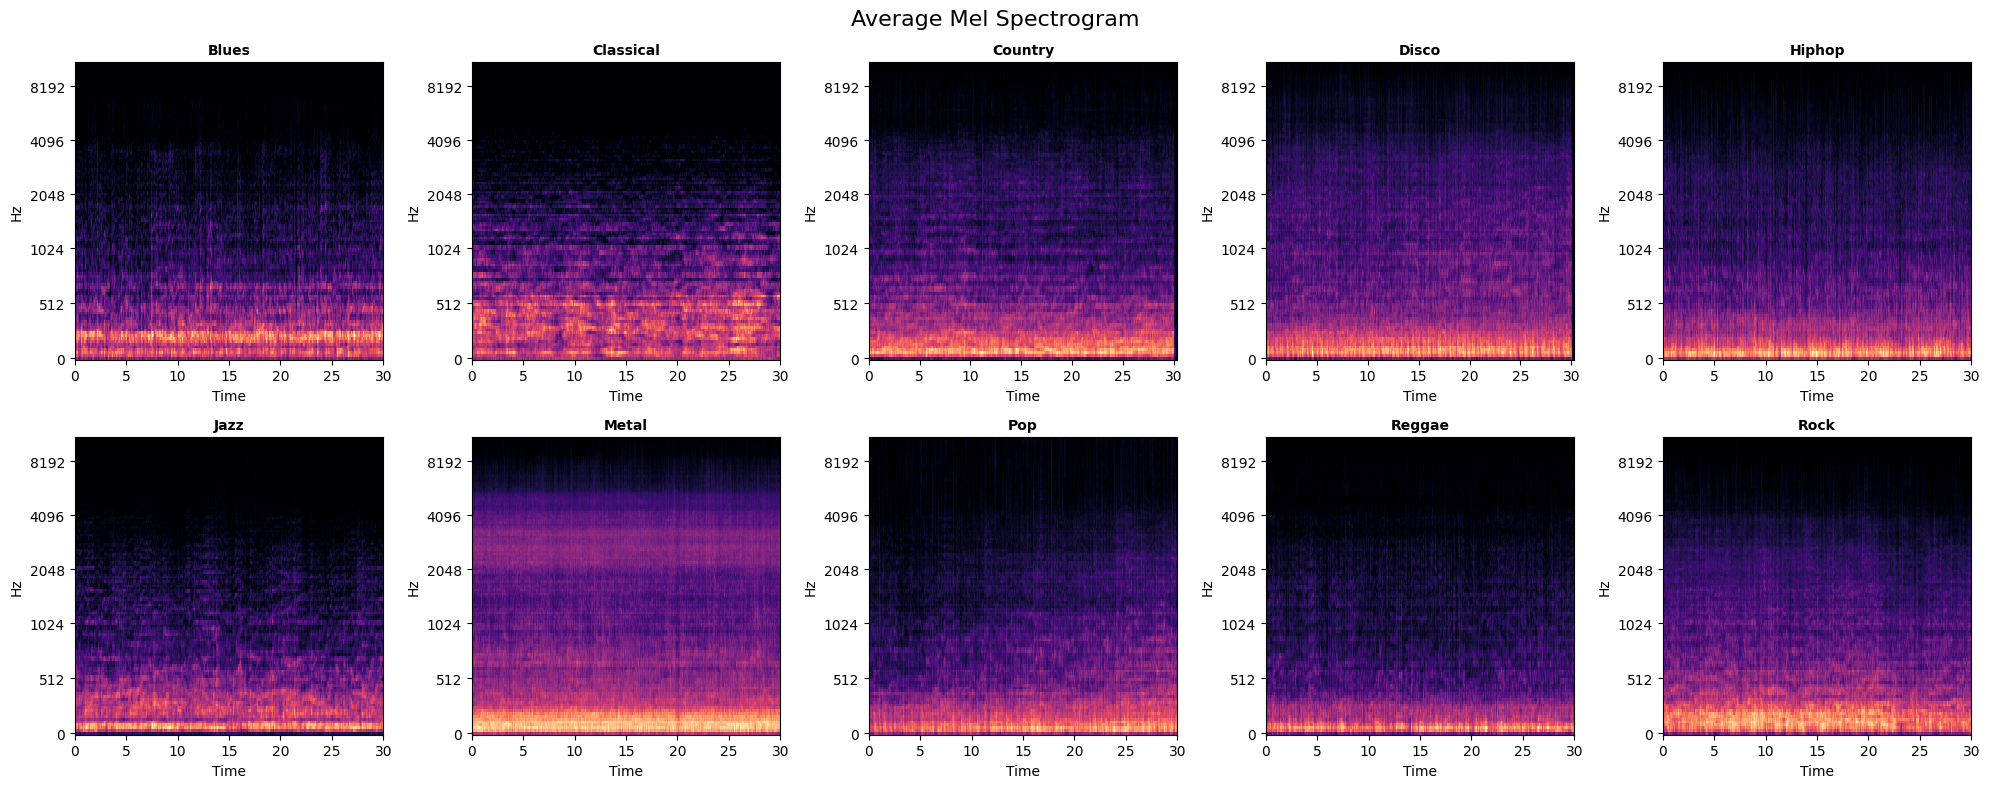

In [ ]:
# The averages of each genre


fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns

fig.suptitle('Average Spectrogram', fontsize=16)

axes = axes.flatten()

for idx, genre in enumerate(sorted(genres_list)):

    genre_files = [f for f in audio_files if genre in f]

    # Calculate spectrograms
    spectrograms = []

    for file in genre_files[:20]:  # Use first 20 files to save time

        y_temp, sr_temp = librosa.load(file)
        D_temp = librosa.stft(y_temp)

        S_db_temp = librosa.amplitude_to_db(np.abs(D_temp), ref=np.max)
        spectrograms.append(S_db_temp)

    # Average the spectrograms

    max_time = max([s.shape[1] for s in spectrograms])

    padded_specs = [np.pad(s, ((0, 0), (0, max_time - s.shape[1])), constant_values=-80)
                    for s in spectrograms]

    avg_spectrogram = np.mean(padded_specs, axis=0)

    # now we show the plot
    img = librosa.display.specshow(avg_spectrogram, x_axis='time', y_axis='log', ax=axes[idx], cmap='viridis')

    axes[idx].set_title(genre.capitalize(), fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Time')
    axes[idx].set_ylabel('Hz')

plt.tight_layout()

plt.show()

# Mel-spectrograms average for each genre
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

fig.suptitle('Average Mel Spectrogram', fontsize=16)
axes = axes.flatten()

for idx, genre in enumerate(sorted(genres_list)):


    genre_files = [f for f in audio_files if genre in f]

    mel_spectrograms = []
    for file in genre_files[:20]:  # 20 files

        y_temp, sr_temp = librosa.load(file)
        S_temp = librosa.feature.melspectrogram(y=y_temp, sr=sr_temp, n_mels=128)

        S_db_temp = librosa.amplitude_to_db(np.abs(S_temp), ref=np.max)
        mel_spectrograms.append(S_db_temp)

    # Average
    max_time = max([s.shape[1] for s in mel_spectrograms])

    padded_mels = [np.pad(s, ((0, 0), (0, max_time - s.shape[1])), constant_values=-80)
                   for s in mel_spectrograms]

    avg_mel = np.mean(padded_mels, axis=0)


    img = librosa.display.specshow(avg_mel, x_axis='time', y_axis='mel', ax=axes[idx], cmap='magma')

    axes[idx].set_title(genre.capitalize(), fontsize=10, fontweight='bold')

    axes[idx].set_xlabel('Time')

    axes[idx].set_ylabel('Hz')

plt.tight_layout()

plt.show()

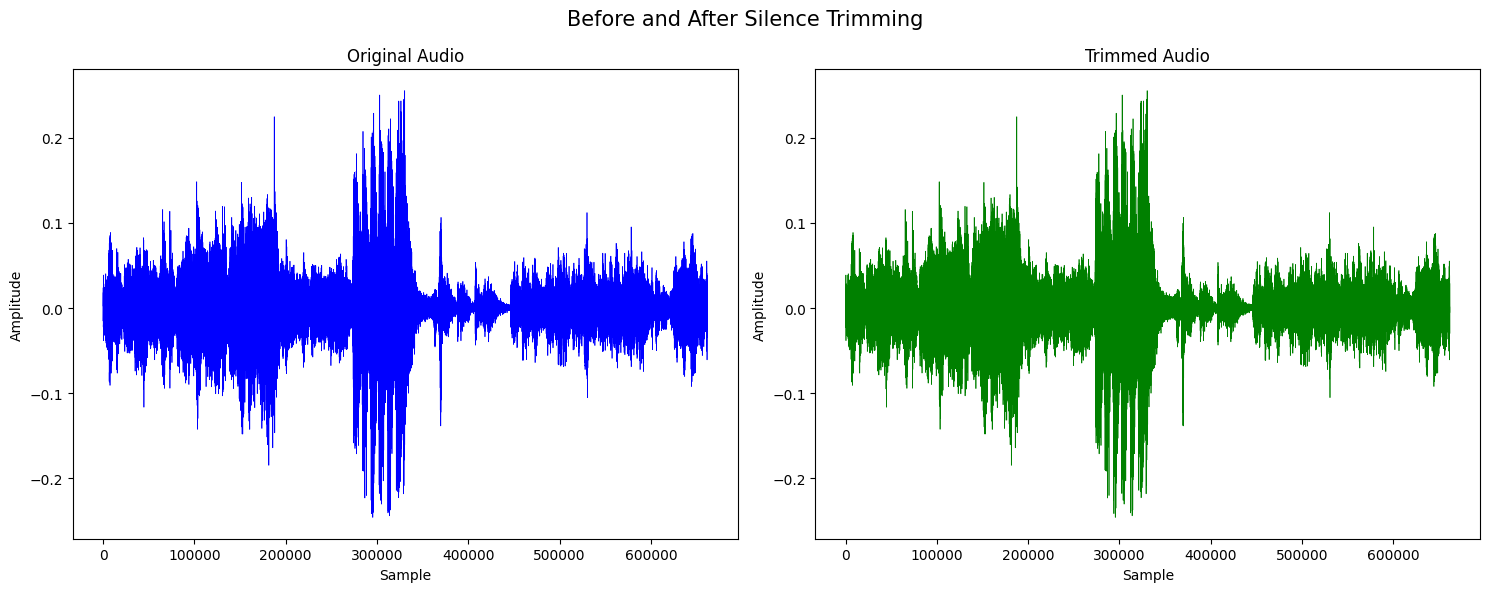

Original length: 661794 samples
Trimmed length:  661794 samples


In [ ]:
# The before and after trimming comparison


fig, axes = plt.subplots(1, 2, figsize=(15, 6))

fig.suptitle('Before and After Silence Trimming', fontsize=15)

y_example, sr_example = librosa.load(audio_files[0])

y_trimmed, _ = librosa.effects.trim(y_example, top_db=20)

axes[0].plot(y_example, linewidth=0.5, color='blue')

axes[0].set_title('Original Audio')

axes[0].set_ylabel('Amplitude')

axes[0].set_xlabel('Sample')

axes[1].plot(y_trimmed, linewidth=0.5, color='green')

axes[1].set_title('Trimmed Audio')

axes[1].set_ylabel('Amplitude')

axes[1].set_xlabel('Sample')

plt.tight_layout()

plt.show()

print(f"Original length: {len(y_example)} samples")

print(f"Trimmed length:  {len(y_trimmed)} samples")

/tmp/ipython-input-1521265103.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y_temp, sr_temp = librosa.load(file)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping bad file: jazz.00054.wav


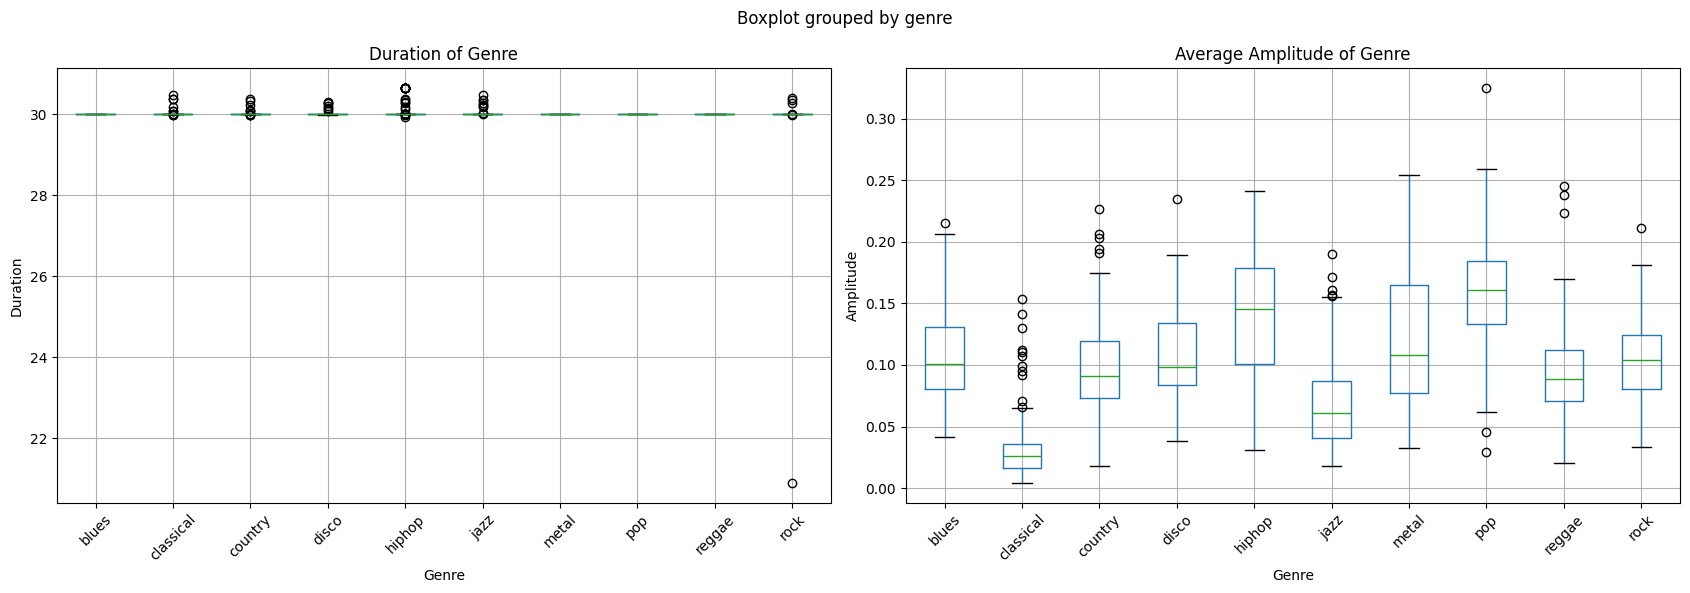

Total files: 992
Duration outliers:  1
               file genre   duration
299  rock.00092.wav  rock  20.896961
Amplitude outliers: 1
              file genre  avg_amplitude
746  pop.00062.wav   pop       0.324852


In [ ]:
# This is to help us find the outliers in the audios


outlier_data = []

badfiles = []

for idx, file in enumerate(audio_files):

    try:
        y_temp, sr_temp = librosa.load(file)

        duration = len(y_temp) / sr_temp

        avg_amplitude = np.mean(np.abs(y_temp))

        outlier_data.append({

            'file': os.path.basename(file), 'genre': os.path.basename(os.path.dirname(file)), 'duration': duration, 'avg_amplitude': avg_amplitude,})

    except Exception as e:

        badfiles.append(os.path.basename(file))

        print(f"Skipping bad file: {os.path.basename(file)}")


df_outliers = pd.DataFrame(outlier_data)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(17, 6))

fig.suptitle('Outlier Detection', fontsize=15)

# Duration
df_outliers.boxplot(column='duration', by='genre', ax=axes[0], rot=45)

axes[0].set_title('Duration of Genre')

axes[0].set_ylabel('Duration')

axes[0].set_xlabel('Genre')

# Amplitude
df_outliers.boxplot(column='avg_amplitude', by='genre', ax=axes[1], rot=45)

axes[1].set_title('Average Amplitude of Genre')

axes[1].set_ylabel('Amplitude')

axes[1].set_xlabel('Genre')

plt.tight_layout()

plt.show()

# Show the outliers found
duration_mean = df_outliers['duration'].mean()

duration_std = df_outliers['duration'].std()

duration_outliers = df_outliers[(df_outliers['duration'] < duration_mean - 3*duration_std) | (df_outliers['duration'] > duration_mean + 3*duration_std)]

amp_mean = df_outliers['avg_amplitude'].mean()

amp_std = df_outliers['avg_amplitude'].std()

amp_outliers = df_outliers[(df_outliers['avg_amplitude'] < amp_mean - 3*amp_std) | (df_outliers['avg_amplitude'] > amp_mean + 3*amp_std)]

print(f"Total files: {len(df_outliers)}")

print(f"Duration outliers:  {len(duration_outliers)}")

if len(duration_outliers) > 0:

    print(duration_outliers[['file', 'genre', 'duration']])

print(f"Amplitude outliers: {len(amp_outliers)}")

if len(amp_outliers) > 0:

  print(amp_outliers[['file', 'genre', 'avg_amplitude']])

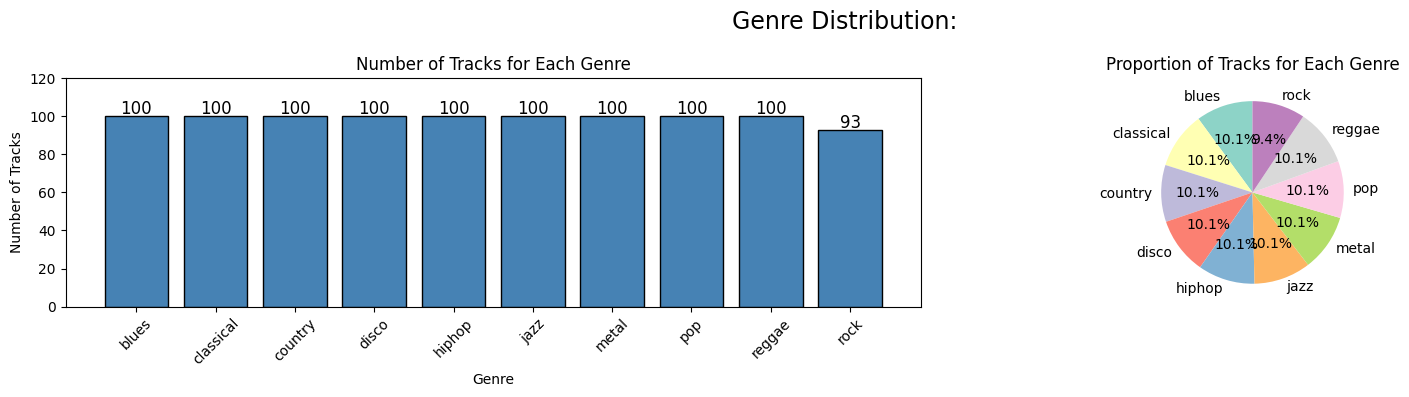

Distribution:
Total tracks: 993
Number of genres: 10

Tracks per genre:
blues: 100 tracks
classical: 100 tracks
country: 100 tracks
disco: 100 tracks
hiphop: 100 tracks
jazz: 100 tracks
metal: 100 tracks
pop: 100 tracks
reggae: 100 tracks
rock: 93 tracks


In [ ]:
# Distribution



# We have to count the tracks of each genre and sort them

genres_list_all = [os.path.basename(os.path.dirname(f)) for f in audio_files]

genre_counts = Counter(genres_list_all)


genres_sorted = sorted(genre_counts.keys())
counts_sorted = [genre_counts[g] for g in genres_sorted]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(17, 4))

fig.suptitle('Genre Distribution:', fontsize=17)

# Bar
axes[0].bar(genres_sorted, counts_sorted, color='steelblue', edgecolor='black')

axes[0].set_title('Number of Tracks for Each Genre')

axes[0].set_xlabel('Genre')

axes[0].set_ylabel('Number of Tracks')

axes[0].set_ylim(0, 120)  # set the y limit for number of tracks

axes[0].tick_params(axis='x', rotation=45)

# The count of each bar
for i, count in enumerate(counts_sorted):

    axes[0].text(i, count + 1, str(count), ha='center', fontsize=12)

# Pie chart

axes[1].pie(counts_sorted, labels=genres_sorted, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)

axes[1].set_title('Proportion of Tracks for Each Genre')

plt.tight_layout()

plt.show()

# The summary of the distribution

print("Distribution:")

print(f"Total tracks: {sum(counts_sorted)}")

print(f"Number of genres: {len(genres_sorted)}")

print(f"\nTracks per genre:")

for genre, count in sorted(genre_counts.items()):

    print(f"{genre}: {count} tracks")


In [ ]:
# Consistency

import hashlib

consistency_data = []
bad_files = []

# store metadata as dataframe
for file in audio_files:
    try:
      y_temp, sr_temp = librosa.load(file, sr=None)
      duration = len(y_temp) / sr_temp
      avg_amp = np.mean(np.abs(y_temp))
      genre = os.path.basename(os.path.dirname(file))

      with open(file, "rb") as fh:
          file_hash = hashlib.md5(fh.read()).hexdigest()

      consistency_data.append({
          "file": os.path.basename(file),
          "genre": genre,
          "duration": duration,
          "sr": sr_temp,
          "avg_amp": avg_amp,
          "n_samples": len(y_temp),
          "hash": file_hash,
      })

    except Exception as e:
        bad_files.append(os.path.basename(file))
        print(f"Skipping bad file: {os.path.basename(file)}")

df_c = pd.DataFrame(consistency_data)
print(f"Files loaded: {len(df_c)} | Skipped: {len(bad_files)}")

# detect if we have any empty audio files using 0.001 as our heuristic
empty_files = df_c[df_c["avg_amp"] <= 0.001]

print(f"\nEmpty files: {len(empty_files)}")
if len(empty_files):
  print(empty_files[["file", "genre", "avg_amp"]].to_string(index=False))

# track uniform shape (files have roughly same duration and sample rate)
print("\nUnique sample rates:", df_c["sr"].unique())
print("Unique durations (rounded to 1dp):", df_c["duration"].round(1).unique())


# track duplicates (compare file hashes to check for identifical audio files)
dup_files = df_c[df_c.duplicated(subset="hash", keep=False)]

print(f"\nDuplicate files: {len(dup_files)}")
if len(dup_files):
    print(dup_files[["file", "genre", "hash"]].to_string(index=False))



/tmp/ipython-input-3264002555.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  y_temp, sr_temp = librosa.load(file, sr=None)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping bad file: jazz.00054.wav
Files loaded: 992 | Skipped: 1

Empty files: 0

Unique sample rates: [22050]
Unique durations (rounded to 1dp): [30.  30.2 30.4 30.3 30.5 30.1 20.9 30.6 29.9]

Duplicate files: 28
            file  genre                             hash
reggae.00082.wav reggae a2afab9cf2b8d73dc54823599f558116
reggae.00081.wav reggae a2afab9cf2b8d73dc54823599f558116
  rock.00016.wav   rock 00025a41bc991e8a8d5232e6660df86f
hiphop.00039.wav hiphop 86985cbc22cbf7f75e6054920676d2e6
hiphop.00045.wav hiphop 86985cbc22cbf7f75e6054920676d2e6
hiphop.00078.wav hiphop 9a42deaa9beb74a739c30c624830841f
hiphop.00076.wav hiphop 9a42deaa9beb74a739c30c624830841f
 metal.00034.wav  metal 108396866a0b7bd6120ce0f2c3647a33
 metal.00044.wav  metal 8ee4d1bc07a8ac9fb7c4b05eea5177ce
 metal.00045.wav  metal 6fb04d43192a9b025402fe6aca3f7e2b
 metal.00043.wav  metal cba45f2118073a824b026587a281f72e
 metal.00041.wav  metal 6e6c3b5f83e2bc1bcbbedc3c0aaec346
 metal.00042.wav  metal dc24521ee6a1d42158ba0

Librosa Features and Definitions

1. Chroma STFT (librosa.feature.chroma_stft)
- analyzes harmonic context by converting audio using STFT and mapping into 12 bins representing different classes of the chromatic scale


2. RMS / Root Mean Square (librosa.feature.rms)
- measures the average loudness and power of a signal over time
- measures overall loudness of a track better than measuring by only tracking its peaks


3. Spectral  (librosa.feature.spectral_centroid)
- indicates the "center of mass" of the frequency spectrum
- correlates with the impresssion of "brightness of sound"


4. Spectral  (librosa.feature.spectral_bandwidth)
- defines range of frequencies in a sound
- narrow bandwidth ~ purer, tonal
- wider bandwidth ~ complex, noiser


5. Rolloff (librosa.feature.spectral_rolloff)
- cutoff frequency, where most of total spectral energy falls


6. Zero Crossing Rate (librosa.feature.zero_crossing_rate)
- how often audio waveform crosses zero amplitude per second
- low ZCR ~ smooth, pitched tonal content
- high ZCR ~ noisy/percussive


7. Harmony (librosa.effects.hpss)
- measurement of harmonic content (combination of notes creating chords and depth)

8. Perceptr (librosa.effects.hpss)
- measures percussive/rhythmic content (sequence/duration of notes driving movement)


9. Tempo (librosa.beat.beat_track)
- beats per minute (singular value)


10. MFCCs / Mel-Frequency Cepstral Coefficients (librosa.feature.mfcc)
- representation of short-term power spectrum of sound
- each component captures a different aspect of the spectral envelope


